In [ ]:
# Python_Versiom = 3.12.1
# %pip install pandas numpy statsmodels pingouin matplotlib seaborn openpyxl
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [13]:
file_path  = r"/workspaces/Impact-of-Employee-Emotions-on-Productivity-with-the-Role-of-AI-Policy-Research/data/employee_emotion_productivity.csv"
df = pd.read_csv(file_path)

# Strip spaces in column names
df.columns = df.columns.str.strip()

In [14]:
likert_map = {
    "Strongly Disagree": 1, "Disagree": 2, "Neutral": 3,
    "Agree": 4, "Strongly Agree": 5,
    "strongly disagree": 1, "disagree": 2, "neutral": 3,
    "agree": 4, "strongly agree": 5,
    "Strongly agree": 5, "Disagree ": 2, "Neutral ": 3, "Agree ": 4,
    "Strongly disagree": 1, "Strongly Agree ": 5
}

In [15]:
df = df.applymap(lambda x: likert_map[x.strip()] if isinstance(x, str) and x.strip() in likert_map else x)


In [16]:
# Assuming order is same as your sample:
pos_cols = df.columns[6:11]    # Employee Emotions
eng_cols = df.columns[11:16]   # Work Engagement
prod_cols = df.columns[16:21]  # Productivity
ban_cols = df.columns[21:26]   # BAN AI Policy

# Reverse score negative emotion question (the 4th one)
df[pos_cols[3]] = 6 - df[pos_cols[3]]


In [17]:
df["PositiveEmotion"] = df[pos_cols].mean(axis=1)
df["WorkEngagement"] = df[eng_cols].mean(axis=1)
df["Productivity"] = df[prod_cols].mean(axis=1)
df["BANAI"] = df[ban_cols].mean(axis=1)

model_df = df[["PositiveEmotion", "WorkEngagement", "Productivity", "BANAI"]].dropna()

In [18]:
alphas = {
    "PositiveEmotion": pg.cronbach_alpha(data=df[pos_cols])[0],
    "WorkEngagement": pg.cronbach_alpha(data=df[eng_cols])[0],
    "Productivity": pg.cronbach_alpha(data=df[prod_cols])[0],
    "BANAI": pg.cronbach_alpha(data=df[ban_cols])[0],
}
print("\n=== Reliability (Cronbach’s Alpha) ===")
for k, v in alphas.items():
    print(f"{k}: {v:.3f}")


=== Reliability (Cronbach’s Alpha) ===
PositiveEmotion: 0.212
WorkEngagement: 0.489
Productivity: 0.468
BANAI: 0.312


In [19]:
print("\n=== Step 1: Mediation (a-path) ===")
a_model = smf.ols("WorkEngagement ~ PositiveEmotion * BANAI", data=model_df).fit()
print(a_model.summary())

print("\n=== Step 2: Outcome (b-path) ===")
b_model = smf.ols("Productivity ~ WorkEngagement * BANAI + PositiveEmotion", data=model_df).fit()
print(b_model.summary())


=== Step 1: Mediation (a-path) ===
                            OLS Regression Results                            
Dep. Variable:         WorkEngagement   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     22.49
Date:                Sat, 25 Oct 2025   Prob (F-statistic):           3.61e-13
Time:                        20:27:06   Log-Likelihood:                -322.60
No. Observations:                 305   AIC:                             653.2
Df Residuals:                     301   BIC:                             668.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

In [20]:
ban_mean = model_df["BANAI"].mean()
ban_sd = model_df["BANAI"].std()

def indirect_effect(ban_value):
    df_temp = model_df.copy()
    df_temp["BANAI_centered"] = df_temp["BANAI"] - ban_mean + ban_value
    a = smf.ols("WorkEngagement ~ PositiveEmotion * BANAI_centered", data=df_temp).fit().params
    b = smf.ols("Productivity ~ WorkEngagement * BANAI_centered + PositiveEmotion", data=df_temp).fit().params
    return a["PositiveEmotion"] * b["WorkEngagement"]

low_indirect = indirect_effect(ban_mean - ban_sd)
med_indirect = indirect_effect(ban_mean)
high_indirect = indirect_effect(ban_mean + ban_sd)

print("\n=== Indirect (Mediated) Effects ===")
print(f"Low BANAI Policy:  {low_indirect:.3f}")
print(f"Mean BANAI Policy: {med_indirect:.3f}")
print(f"High BANAI Policy: {high_indirect:.3f}")


=== Indirect (Mediated) Effects ===
Low BANAI Policy:  -0.007
Mean BANAI Policy: 0.058
High BANAI Policy: 0.161


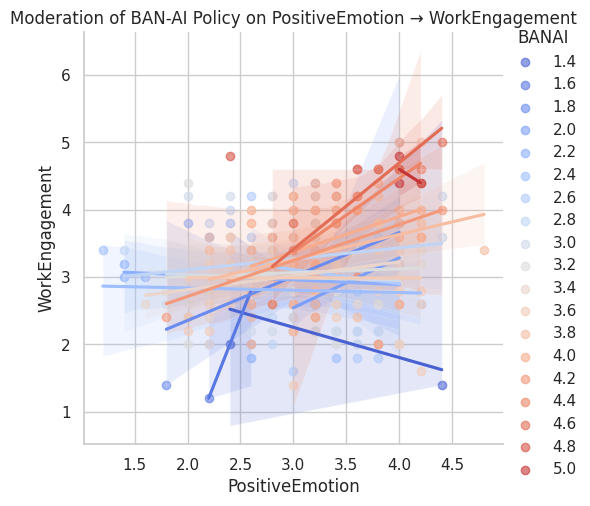

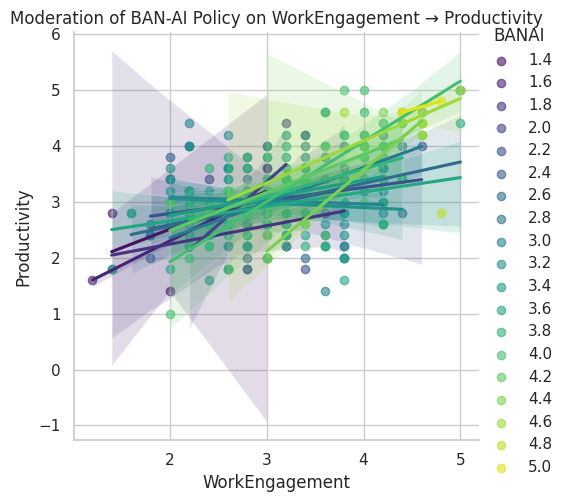

In [21]:
sns.set(style="whitegrid")

# Moderation of PositiveEmotion → WorkEngagement
sns.lmplot(data=model_df, x="PositiveEmotion", y="WorkEngagement", hue="BANAI",
           palette="coolwarm", scatter_kws={'alpha':0.6})
plt.title("Moderation of BAN-AI Policy on PositiveEmotion → WorkEngagement")
plt.savefig("moderation_a_path.png", dpi=300)
plt.show()

# Moderation of WorkEngagement → Productivity
sns.lmplot(data=model_df, x="WorkEngagement", y="Productivity", hue="BANAI",
           palette="viridis", scatter_kws={'alpha':0.6})
plt.title("Moderation of BAN-AI Policy on WorkEngagement → Productivity")
plt.savefig("moderation_b_path.png", dpi=300)
plt.show()

In [26]:
import openpyxl
model_df.to_excel("cleaned_constructs.xlsx", index=False)
a_model_df = pd.DataFrame(a_model.summary().tables[1].data)
b_model_df = pd.DataFrame(b_model.summary().tables[1].data)

a_model_df.to_csv("a_path_results.csv", index=False)
b_model_df.to_csv("b_path_results.csv", index=False)

print("\n✅ Analysis Complete! Files Saved:")
print(" - cleaned_constructs.xlsx")
print(" - a_path_results.csv")
print(" - b_path_results.csv")
print(" - moderation plots (2 PNGs)")


✅ Analysis Complete! Files Saved:
 - cleaned_constructs.xlsx
 - a_path_results.csv
 - b_path_results.csv
 - moderation plots (2 PNGs)
